In [1]:
import os 
import json
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from stylesheet import color_palette, marker, marker_size, line_width, markeredgewidth

In [2]:
def get_results_dict(experiment: str):
    try:
        if 'main_2025-04-09_19-06-39' in experiment:
            df = pd.read_csv(os.path.join(experiment, "progress.csv"))
            df.rename(columns={
                'training_loss': 'loss_train',
                'training_accuracy': 'accuracy_train',
                'validation_loss': 'loss_val',
                'validation_accuracy': 'accuracy_val'
            }, inplace=True)
        else:
            df = pd.read_csv(os.path.join(experiment, "training_data_epoch.csv"))
        min_loss_val_index = df['loss_val'].idxmin()
    except:
        df = pd.read_csv(os.path.join(experiment, "progress.csv"))
        min_loss_val_index = df['validation_loss'].idxmin()

    min_loss_val_row = df.loc[min_loss_val_index]

    with open(os.path.join(experiment, "params.json"), "r") as f:
        params = json.load(f)

    combined_dict = {**params, **min_loss_val_row.to_dict()}

    return combined_dict

def compute_accuracy_metrics(basepath_cnn, basepath_vqc, basepath_mpo, basepath_svm):
    results = {}
    # CNN
    if basepath_cnn:
        dirs = [d for d in os.listdir(basepath_cnn) if os.path.isdir(os.path.join(basepath_cnn, d))]
        results_cnn = pd.DataFrame([get_results_dict(os.path.join(basepath_cnn, d)) for d in dirs])
        mean_accuracy_cnn = results_cnn.groupby('compression_depth')['accuracy_val'].mean()
        std_accuracy_cnn = results_cnn.groupby('compression_depth')['accuracy_val'].std()

        results["mean_accuracy_uncompressed_cnn"] = mean_accuracy_cnn[mean_accuracy_cnn.index == 0]
        results["mean_accuracy_compressed_cnn"] = mean_accuracy_cnn[mean_accuracy_cnn.index != 0]
        results["std_accuracy_compressed_cnn"] = std_accuracy_cnn[std_accuracy_cnn.index != 0]

    # VQC
    if basepath_vqc:
        dirs = [d for d in os.listdir(basepath_vqc) if os.path.isdir(os.path.join(basepath_vqc, d))]
        results_vqc = pd.DataFrame([get_results_dict(os.path.join(basepath_vqc, d)) for d in dirs])
        mean_accuracy_vqc = results_vqc.groupby('compression_depth')['accuracy_val'].mean()
        std_accuracy_vqc = results_vqc.groupby('compression_depth')['accuracy_val'].std()
    
        results["mean_accuracy_uncompressed_vqc"] = mean_accuracy_vqc[mean_accuracy_vqc.index == 0]
        results["mean_accuracy_compressed_vqc"] = mean_accuracy_vqc[mean_accuracy_vqc.index != 0]
        results["std_accuracy_compressed_vqc"] = std_accuracy_vqc[std_accuracy_vqc.index != 0]


    # MPO
    if basepath_mpo:
        dirs = [d for d in os.listdir(basepath_mpo) if os.path.isdir(os.path.join(basepath_mpo, d))]
        results_mpo = pd.DataFrame([get_results_dict(os.path.join(basepath_mpo, d)) for d in dirs])
        try:
            mean_accuracy_mpo = results_mpo.groupby('compression_level')['validation_accuracy'].mean()
            std_accuracy_mpo = results_mpo.groupby('compression_level')['validation_accuracy'].std()
        except KeyError:
            mean_accuracy_mpo = results_mpo.groupby('compression_depth')['validation_accuracy'].mean()
            std_accuracy_mpo = results_mpo.groupby('compression_depth')['validation_accuracy'].std()

        results["mean_accuracy_uncompressed_mpo"] = mean_accuracy_mpo[mean_accuracy_mpo.index == 0]
        results["mean_accuracy_compressed_mpo"] = mean_accuracy_mpo[mean_accuracy_mpo.index != 0]
        results["std_accuracy_compressed_mpo"] = std_accuracy_mpo[std_accuracy_mpo.index != 0]

    # SVM
    if basepath_svm:
        csv_files = glob.glob(os.path.join(basepath_svm, "*.csv"))
        df_list = [pd.read_csv(file) for file in csv_files]
        results_svm = pd.concat(df_list, ignore_index=True)
        mean_accuracy_svm = results_svm.groupby('compression_level')['val_accuracy'].mean()
        std_accuracy_svm = results_svm.groupby('compression_level')['val_accuracy'].std()

        results["mean_accuracy_uncompressed_svm"] = mean_accuracy_svm[mean_accuracy_svm.index == 0]
        results["mean_accuracy_compressed_svm"] = mean_accuracy_svm[mean_accuracy_svm.index != 0]
        results["std_accuracy_compressed_svm"] = std_accuracy_svm[std_accuracy_svm.index != 0]

    # Define mean and std accuracy for each model

    return results

basepath_mnist_cnn = "/raid/home/q615005/dev/data_compression/classifier/_results/cnn/main_2025-03-03_22-40-48/"
basepath_mnist_vqc_nonlin = "/raid/home/q615005/dev/data_compression/classifier/_results/NonLinearVQC_shadow/main_2025-03-03_13-50-43/"
basepath_mnist_mpo = "/raid/home/q615005/dev/data_compression/classifier/_results/mpo/main_2025-03-02_15-46-02/"
basepath_mnist_svm = "/raid/home/q615005/dev/data_compression/classifier/_results/svm/mnist_20250304_084143/"

metrics_mnist = compute_accuracy_metrics(basepath_mnist_cnn, basepath_mnist_vqc_nonlin, basepath_mnist_mpo, basepath_mnist_svm)

# basepath_fashion_mnist_cnn = "/raid/home/q615005/dev/data_compression/classifier/_results/cnn/main_2025-04-25_09-49-57/"
basepath_fashion_mnist_cnn = "/raid/home/q615005/dev/data_compression/classifier/_results/cnn/main_2025-04-25_11-02-41/"
basepath_fashion_mnist_vqc_nonlin = "/raid/home/q615005/dev/data_compression/classifier/_results/NonLinearVQC_shadow/main_2025-03-14_23-01-07/"
basepath_fashion_mnist_mpo = "/raid/home/q615005/dev/data_compression/classifier/_results/mpo/main_2025-03-15_14-53-41/"
basepath_fashion_mnist_svm = "/raid/home/q615005/dev/data_compression/classifier/_results/svm/fashion_mnist_20250325_070559"

metrics_fashion_mnist = compute_accuracy_metrics(basepath_fashion_mnist_cnn, basepath_fashion_mnist_vqc_nonlin, basepath_fashion_mnist_mpo, basepath_fashion_mnist_svm)

basepath_cifar10_cnn = "/raid/home/q615005/dev/data_compression/classifier/_results/cnn/main_2025-04-23_23-48-00"
basepath_cifar10_vqc_nonlin = "/raid/home/q615005/dev/data_compression/classifier/_results/_results_H100_2/NonLinearVQC_shadow/main_2025-03-04_22-06-59/"
basepath_cifar10_mpo = "/raid/home/q615005/dev/data_compression/classifier/_results/_results_H100_2/mpo/main_2025-03-05_22-01-06/"
basepath_cifar10_svm = "/raid/home/q615005/dev/data_compression/classifier/_results/_results_H100_2/svm/cifar10_20250304_220719/"

metrics_cifar = compute_accuracy_metrics(basepath_cifar10_cnn, basepath_cifar10_vqc_nonlin, basepath_cifar10_mpo, basepath_cifar10_svm)

basepath_imagenette_cnn = "/raid/home/q615005/dev/data_compression/classifier/_results/cnn/main_2025-04-24_09-17-52/"
basepath_imagenette_mpo = "/raid/home/q615005/dev/data_compression/classifier/_results/mpo/main_2025-03-26_04-26-04"
basepath_imagenette_svm = "/raid/home/q615005/dev/data_compression/classifier/_results/svm/imagenette_128_20250325_024317"

metrics_imagenette = compute_accuracy_metrics(basepath_imagenette_cnn, False, basepath_imagenette_mpo, basepath_imagenette_svm)



In [3]:
def plot_dataset(metrics, title, y_ticks, ax, legend=False):
    if "mean_accuracy_uncompressed_cnn" in metrics.keys():
        ax.axhline(y=metrics["mean_accuracy_uncompressed_cnn"][0] * 100, color=color_palette["blue"], linestyle='--', linewidth=2, zorder=1)
        # Plot CNN
        sns.lineplot(
            x=metrics["mean_accuracy_compressed_cnn"].index,
            y=metrics["mean_accuracy_compressed_cnn"] * 100,
            ax=ax,
            marker=marker["circle"],
            label='CNN' if legend else None,
            color=color_palette["blue"],
            linestyle='solid',
            markersize=marker_size,
            linewidth=line_width,
            markeredgewidth=markeredgewidth,
            markeredgecolor='black'
        )
        ax.fill_between(
            metrics["mean_accuracy_compressed_cnn"].index,
            (metrics["mean_accuracy_compressed_cnn"] - metrics["std_accuracy_compressed_cnn"]) * 100,
            (metrics["mean_accuracy_compressed_cnn"] + metrics["std_accuracy_compressed_cnn"]) * 100,
            color=color_palette["blue"],
            alpha=0.2
        )

    # Plot MPO
    if "mean_accuracy_uncompressed_mpo" in metrics.keys():
        try:
            ax.axhline(y=metrics["mean_accuracy_uncompressed_mpo"][0] * 100, color=color_palette["red"], linestyle='--', linewidth=2, zorder=1)
        except:
            print("KeyError: mean_accuracy_uncompressed_mpo")
            pass
        sns.lineplot(
            x=metrics["mean_accuracy_compressed_mpo"].index,
            y=metrics["mean_accuracy_compressed_mpo"] * 100,
            ax=ax,
            marker=marker["square"],
            label='MPO' if legend else None,
            color=color_palette["red"],
            linestyle='solid',
            markersize=marker_size,
            linewidth=line_width,
            markeredgewidth=markeredgewidth,
            markeredgecolor='black'
        )
        ax.fill_between(
            metrics["mean_accuracy_compressed_mpo"].index,
            (metrics["mean_accuracy_compressed_mpo"] - metrics["std_accuracy_compressed_mpo"]) * 100,
            (metrics["mean_accuracy_compressed_mpo"] + metrics["std_accuracy_compressed_mpo"]) * 100,
            color=color_palette["red"],
            alpha=0.2
        )

    # Plot SVM
    if "mean_accuracy_uncompressed_svm" in metrics.keys():
        ax.axhline(y=metrics["mean_accuracy_uncompressed_svm"][0] * 100, color=color_palette["green"], linestyle='--', linewidth=2, zorder=1)
        sns.lineplot(
            x=metrics["mean_accuracy_compressed_svm"].index,
            y=metrics["mean_accuracy_compressed_svm"] * 100,
            ax=ax,
            marker=marker["triangle"],
            label='SVM' if legend else None,
            color=color_palette["green"],
            linestyle='solid',
            markersize=marker_size,
            linewidth=line_width,
            markeredgewidth=markeredgewidth,
            markeredgecolor='black'
        )
        ax.fill_between(
            metrics["mean_accuracy_compressed_svm"].index,
            (metrics["mean_accuracy_compressed_svm"] - metrics["std_accuracy_compressed_svm"]) * 100,
            (metrics["mean_accuracy_compressed_svm"] + metrics["std_accuracy_compressed_svm"]) * 100,
            color=color_palette["green"],
            alpha=0.2
        )

    # Plot VQC
    if "mean_accuracy_uncompressed_vqc" in metrics.keys():
        ax.axhline(y=metrics["mean_accuracy_uncompressed_vqc"][0] * 100, color=color_palette["orange"], linestyle='--', linewidth=2, zorder=1)
        sns.lineplot(
            x=metrics["mean_accuracy_compressed_vqc"].index,
            y=metrics["mean_accuracy_compressed_vqc"] * 100,
            ax=ax,
            marker=marker["diamond"],
            label='VQC' if legend else None,
            color=color_palette["orange"],
            linestyle='solid',
            markersize=marker_size,
            linewidth=line_width,
            markeredgewidth=markeredgewidth,
            markeredgecolor='black'
        )
        ax.fill_between(
            metrics["mean_accuracy_compressed_vqc"].index,
            (metrics["mean_accuracy_compressed_vqc"] - metrics["std_accuracy_compressed_vqc"]) * 100,
            (metrics["mean_accuracy_compressed_vqc"] + metrics["std_accuracy_compressed_vqc"]) * 100,
            color=color_palette["orange"],
            alpha=0.2
        )

    # Configure axis
    ax.set_xticks(metrics["mean_accuracy_compressed_svm"].index)
    ax.set_title(title)
    ax.set_xlabel('Layers of encoding circuit')
    ax.grid(True)

    interval = y_ticks[-1] - y_ticks[0]
    ax.set_ylim([y_ticks[0] - 0.05 * interval, y_ticks[-1] + 0.05 * interval])
    ax.set_yticks(y_ticks)

    if legend:
        ax.plot([], [], '--', label="Uncompr." if legend else None, color='grey', linewidth=2)
        ax.legend(loc="lower right")
        ax.set_ylabel('Validation Accuracy [%]')
    else:
        ax.set_ylabel('')


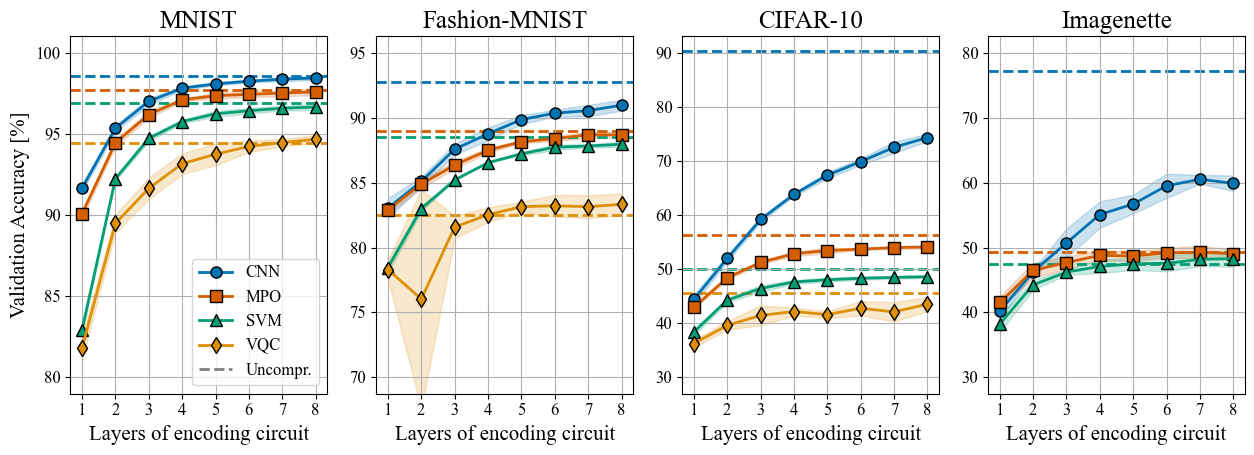

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(12.8, 4.8))
plot_dataset(metrics_mnist, title="MNIST", y_ticks=range(80, 101, 5), ax=axs[0], legend=True)
plot_dataset(metrics_fashion_mnist, title="Fashion-MNIST", y_ticks=range(70, 96, 5), ax=axs[1])
plot_dataset(metrics_cifar, title="CIFAR-10", y_ticks=range(30, 91, 10), ax=axs[2])
plot_dataset(metrics_imagenette, title="Imagenette", y_ticks=range(30, 81, 10), ax=axs[3])
plt.tight_layout()
plt.savefig("compression.pdf")